In [1]:
%matplotlib notebook
import numpy as np
from scipy.optimize import leastsq, brent
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from time import process_time
from numpy.linalg import inv
np.set_printoptions(precision=16)
from Imaging_core_new import *
from Gridding_core import *

In /software/rhel7/lib64/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /software/rhel7/lib64/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /software/rhel7/lib64/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /software/rhel7/lib64/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /software/rhel7/lib64/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

### 1. Read in the data

In [2]:
#########  Read in visibilities ##########
data = np.genfromtxt('out_barray_6d.csv', delimiter = ',')
jj = complex(0,1)
u_original = data.T[0]
v_original = data.T[1]
w_original = -data.T[2]
V_original = data.T[3] + jj*data.T[4]
n_uv = len(u_original)
uv_max = max(np.sqrt(u_original**2+v_original**2))
V,u,v,w = Visibility_minusw(V_original,u_original,v_original,w_original)

#### Determine the pixel size ####
X_size = 900 # image size on x-axis
Y_size = 900 # image size on y-axis
X_min = -np.pi/60. #You can change X_min and X_max in order to change the pixel size.
X_max = np.pi/60.
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -np.pi/60. #You can change Y_min and Y_max in order to change the pixel size.
Y_max = np.pi/60.
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]
pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

The pixel size on x-axis is  23.999999999999996  arcsec


### 2. determine the number of w planes 

In [3]:
W = 7
x0 = 0.25 # only retain the central half of the image
Nw_2R, w_values, dw = Wplanes(W, X_max, Y_max, w, x0)

We will have 37 w-planes


### 3. Improved w-stacking method

### 3.1 3D Gridding


In [4]:
from scipy.special import pro_ang1

## Spheroidal function C(u)
def C(u):
    if np.abs(u) == W/2:
        return 1e-25
    else:
        return (1-(2*u/W)**2)**0.5 * pro_ang1(1, 1, W/2*np.pi, 2*u/W)[0]

In [8]:
Nfft = 600
im_size = 1800
ind = find_nearestw(w_values, w)

#### Gridding on w-axis

In [9]:
V_wgrid, u_wgrid, v_wgrid, beam_wgrid = grid_w_other(V, u, v, w, w_values, W, Nw_2R, ind, dw, C)

Elapsed time during the w-gridding calculation in seconds: 20.791550194


#### Gridding on uv-axis

In [10]:
I_size = int(im_size*2*x0)
I_image = np.zeros((I_size,I_size),dtype = np.complex_)
B_image = np.zeros((I_size,I_size),dtype = np.complex_)

t2_start = process_time() 
for w_ind in range(Nw_2R):
    print ('This is the ', w_ind, 'th level facet out of ',Nw_2R,' w facets.\n')
    V_update = np.asarray(V_wgrid[w_ind])
    u_update = np.asarray(u_wgrid[w_ind])
    v_update = np.asarray(v_wgrid[w_ind])
    beam_update = np.asarray(beam_wgrid[w_ind])
    V_grid, B_grid = grid_uv_other(V_update, u_update, v_update, beam_update, W, im_size, X_max, X_min, Y_max, Y_min, C)
    I_image += FFTnPShift(V_grid, w_values[w_ind], X, Y, im_size, x0)
    B_image += FFTnPShift(B_grid, w_values[w_ind], X, Y, im_size, x0)
    B_grid = np.zeros((im_size,im_size),dtype = np.complex_) 
    V_grid = np.zeros((im_size,im_size),dtype = np.complex_)
t2_stop = process_time()   
print("Elapsed time during the uv-gridding calculation in seconds:", t2_stop-t2_start)  

This is the  0 th level facet out of  37  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  1 th level facet out of  37  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  2 th level facet out of  37  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  3 th level facet out of  37  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  4 th level facet out of  37  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  5 th level facet out of  37  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  6 th level facet out of  37  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  7 th level facet out of  37  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  8 th level facet out of  37  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  9 th level facet out of 

#### Rescale and have a look

<IPython.core.display.Javascript object>


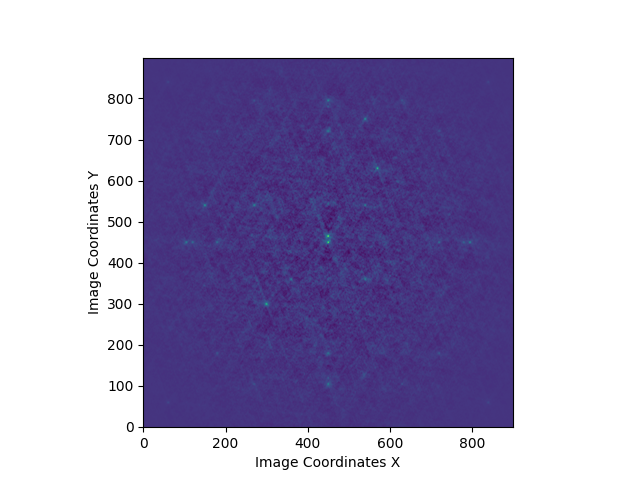

(15.989999479864709+0j)

In [13]:
I_image_now = image_rescale(I_image,im_size, n_uv)
B_image_now = image_rescale(B_image,im_size, n_uv)
plt.figure()
plt.imshow(np.rot90(I_image_now.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()
B_image_now[450,450]

#### Correcting functions h(x)h(y)

#### W= 7, x0 = 0.25

In [14]:
Nfft = 600
# Use these for calculating gridding correction on the FFT grid
M = 32
I_xycorrected = xy_correct_other(I_image_now, im_size, W, C, x0=0.25)
B_xycorrected = xy_correct_other(B_image_now, im_size, W, C, x0=0.25)
#need to change the gridding function 'gridder' inside xy_correct_other

#### Correcting function on z axis

In [15]:
Cor_gridz = z_correct_cal_other(X_min, X_max, Y_min, Y_max, dw, im_size, W, C, x0=0.25)
I_zcorrected = z_correct(I_xycorrected, Cor_gridz, im_size, x0=0.25)
B_zcorrected = z_correct(B_xycorrected, Cor_gridz, im_size, x0=0.25)

### 4 DFT and FFT dirty image difference

<IPython.core.display.Javascript object>


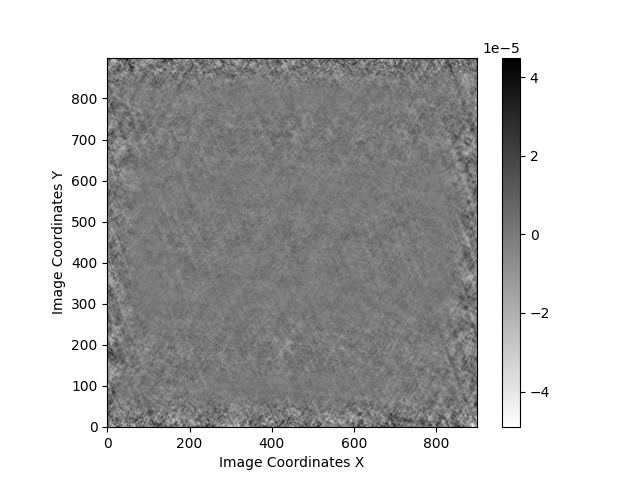

In [16]:
I_DFT = np.loadtxt('I_DFT_900_out6db.csv', delimiter = ',')
I_dif = I_DFT - I_zcorrected.real
plt.figure()
plt.imshow(np.rot90(I_dif,1), cmap='binary', origin = 'lower')
plt.colorbar()
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()

In [17]:
rms = RMS(I_dif, im_size, 0.5, x0=0.25)
print (rms)

4.209128335428349e-06


In [18]:
def pb_cor(pbcor,size,I):
    """
    Primary beam correction
    """
    for i in range(size):
        for j in range(size):
            I[i,j] = I[i,j]/pbcor[i,j]
    return I

from astropy.io import fits
fits_file = 'out_1800.flux.fits'
hdu_list = fits.open(fits_file)
pbcor = hdu_list[0].data
hdu_list.close()
pbcor = pbcor.reshape((1800,1800))
pbcor = pbcor[450:1350,450:1350]

I_dif_r = I_rotation(900,I_dif)
## primary beam correction
I_dif_r_pbcor = pb_cor(pbcor,900,I_dif_r)


<IPython.core.display.Javascript object>


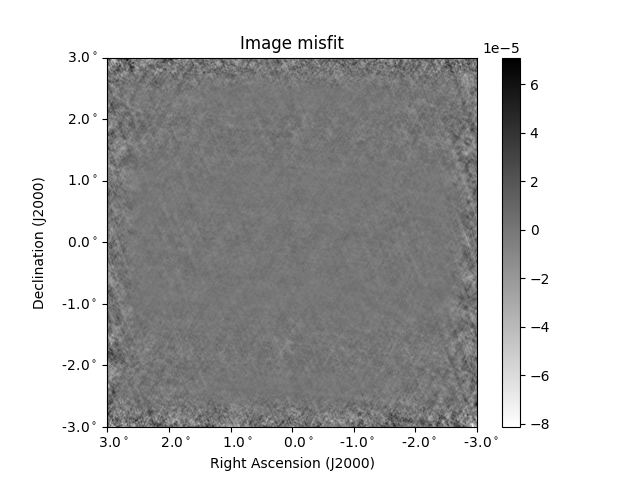

In [20]:
fig4, ax4 = plt.subplots()

img4 = ax4.imshow(I_dif_r_pbcor, cmap='binary', origin = 'lower')
# Where we want the ticks, in pixel locations
ticks = np.array((0,150,300,450,600,750,900))
ticklabelsx = ["{:6.1f}$^\circ$".format(i) for i in (450-ticks)*24/3600.]
ticklabelsy = ["{:6.1f}$^\circ$".format(i) for i in (ticks-450)*24/3600.]
ax4.set_xticks(ticks)
ax4.set_xticklabels(ticklabelsx)
ax4.set_yticks(ticks)
ax4.set_yticklabels(ticklabelsy)
ax4.set_title(r'Image misfit')
ax4.set_xlabel('Right Ascension (J2000)')
ax4.set_ylabel('Declination (J2000)')
fig4.colorbar(img4)
fig4.show()
fig4.savefig('Misfit_W7_speroidal_pbcor.png', dpi=300)

In [21]:
np.savetxt('Difference_spheroidal.csv',I_dif_r_pbcor, delimiter=',')

In [22]:
Nw_2R

37